#Welcome, to my Vision and Perception Project on "Comparison of UAV Detection and Localization"

**Author:** <br>
Alexander Busch<br>
2018082<br>
busch.2018082@studenti.uniroma1.it

**Dataset:**<br>
Multi-Target Detection and Tracking from a Single Camera in Unmanned Aerial Vehicles (UAVs): https://engineering.purdue.edu/~bouman/UAV_Dataset/


** Compared Architectures:**<br>
// Yolov5 by Ultralytics: https://github.com/ultralytics/yolov5/releases

In [ ]:
#@title Mount Drive and Imports
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"         # default location for the drive

drive.mount(ROOT)
print("moved to directory:")
%cd /content/drive/MyDrive/Universität/Vision_and_Perception/Project_UAV_Detection
root_folder = '/content/drive/MyDrive/Universität/Vision_and_Perception/Project_UAV_Detection'
%ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
moved to directory:
/content/drive/MyDrive/Universität/Vision_and_Perception/Project_UAV_Detection
checkpoint/   coco_utils.py  engine.py     transforms.py  vision/
coco_eval.py  data/          __pycache__/  utils.py


In [ ]:
from PIL import Image
import torch
import pandas as pd
import re
import os 
from numpy import index_exp
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Universität/Vision_and_Perception/Project_UAV_Detection/vision/references/detection')

In [ ]:
!pip install cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install pycocotools --quiet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-h2vckrmz
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-h2vckrmz
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done


In [ ]:
#@title Create the Dataset - unpack videos to images

vid_dir = os.path.join(root_folder,"data/videos/train")
out_dir = os.path.join(root_folder,"data/images")

def vid_to_img(video_path, out_dir, vid_idx, one_frame_each):
    video = cv2.VideoCapture(video_path) 
    success = True
    count = 0
    frame_each = one_frame_each

    if vid_idx < 10:
        vid_idx = str(vid_idx).zfill(2) #add leading zero if below 10
    else:
        vid_idx = str(vid_idx)

    while success:
        success,image = video.read()

        if success and (count%frame_each == 0): 
          cv2.imwrite("%s/%d" %(out_dir, count)+ vid_idx+".png", image) # saves images to frame folder 
        if not success:
          print(count)
          print(vid_idx)
        count += 1

    return count

one_frame_each = 10
vid_idx = 0
for vid_idx in range(0, 49):
  video_path = os.path.join(root_folder,vid_dir, "Clip_"+str(vid_idx)+".mov")
  #cnt = vid_to_img(video_path, out_dir, vid_idx, one_frame_each)
  vid_idx += 1

In [ ]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
#@title UAV Dataset 
class uav_dataset(torch.utils.data.Dataset):

    def __init__(self, root, img_dir, annotation_dir, width, height, train, transforms=None):
        self.transforms = transforms
        self.root = root
        self.annotation_dir = os.path.join(self.root, annotation_dir)
        self.img_dir = img_dir
        self.files_dir = os.path.join(self.root, self.img_dir)
        self.height = height
        self.width = width
        self.train = train
        #img should be jpg
        self.imgs = [image for image in sorted(os.listdir(self.files_dir)) if image[-4:]=='.png']
        self.imgs = self.imgs
        self.classes = ['uav']

    def __len__(self):
        return int( len(self.imgs) )

    # returns one dim list with length n*4
    def __prune_annotation__(self, annotations_df, frame_idx):
        
        index = frame_idx+1
        
        annotations_df.drop( index=annotations_df.index[ index: ], axis=0, inplace=True )
        annotations_df.drop( index=annotations_df.index[ :-1 ], axis=0, inplace=True )
        
        ann_list = annotations_df[0].values.tolist()[0] # to list that contains one string

        ann_list = ann_list.split() # to list that contains one entry for each word/number

        for i in range(0, len(ann_list)):
            ann_list[i] = re.sub("[^0-9]", "", str(ann_list[i])) #removes every non digit character

        ann_list = [int(x) for x in ann_list if x != ''] #removes every empty entry

        for i in range(1,len(ann_list),2):
              ann_list[i], ann_list[i+1] = ann_list[i+1], ann_list[i] # swap x and y as they are flipped in the orig dataset

        return ann_list[1:] #remove first element as it is only the timestamp

    def __idx_to_frame_and_vid__(self, idx):
        idx = self.imgs[idx][:-4] #remove .png
        frame_idx = idx[:-2] # select everything but the last two characters (reserved for vid id )
        vid_idx = idx[-2:] # last two characters for vid id
        return frame_idx, vid_idx

    def __getitem__(self, idx):

        frame_idx, vid_idx = self.__idx_to_frame_and_vid__(idx)
        

        
        img_path = os.path.join(self.root, "data/images/", frame_idx + vid_idx + ".png")
        img = Image.open(img_path).convert("RGB")
        

        vid_idx = vid_idx if int(vid_idx) > 10 else vid_idx[1:] #remove leading zero if present
        label_path =  os.path.join(self.root,self.annotation_dir, "Clip_"+vid_idx+"_gt.txt")
        bboxes_raw =  self.__prune_annotation__(pd.read_csv(label_path, sep='\n', header=None) , int(frame_idx))
        
        

        boxes = []
        if(len(bboxes_raw) != 0 ):
          for i in range( 0, len(bboxes_raw) , 4):
            boxes.append(bboxes_raw[i:i+4])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = []
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        if len(boxes) == 0:
          return self.__getitem__(idx+1) #if empty annotation, just take next frame
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([idx]) #e.g. 00 for frist frame of clip 0
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

dataset = uav_dataset(root=root_folder, 
                            img_dir = "data/images", 
                            annotation_dir = "data/video_annotation/annotation", 
                            width=0,
                            height=0,
                            train =True,
                            transforms = get_transform(train=True))
[img, target] = dataset.__getitem__(100)
print(target)

{'boxes': tensor([[803., 217., 824., 232.]]), 'labels': tensor([1]), 'image_id': tensor([100]), 'area': tensor([315.]), 'iscrowd': tensor([0])}


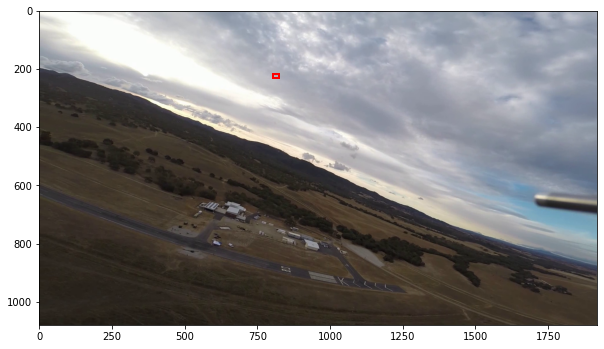

In [ ]:
#@title Plot an Image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,10)
    a.imshow(torch.movedim(img, 0, 2))
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
plot_img_bbox(img, target)



In [ ]:
#@title Model loading: Faster-RCNN 

def get_model_fastRCNN(num_classes, v2):
    # load an instance segmentation model pre-trained on COCO
    if v2:
      model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
    else:
      model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features # get number of input features for the classifier
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace the pre-trained head with a new one

    return model


In [ ]:
#@title dataset initialization

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = uav_dataset(root=root_folder, 
                            img_dir = "data/images", 
                            annotation_dir = "data/video_annotation/annotation", 
                            width=0,
                            height=0,
                            train = True,
                            transforms = get_transform(train=True)
                            )
dataset_test = uav_dataset(root=root_folder, 
                            img_dir = "data/images", 
                            annotation_dir = "data/video_annotation/annotation", 
                            width=0,
                            height=0,
                            train = False,
                            transforms = get_transform(train=False)
                            )

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-300])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-300:])

In [ ]:
#@title dataloaders
import utils
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=6, shuffle=True, num_workers=2,
  collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test, batch_size=1, shuffle=False, num_workers=2,
  collate_fn=utils.collate_fn)

In [ ]:
#@title load model from torch hub

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# get the model using our helper function
model = get_model_fastRCNN(num_classes, v2 =False)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                          momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                              step_size=3,
                                              gamma=0.1)
epoch = 0
warmup_factor = 1.0 / 1000
warmup_iters = min(1000, len(data_loader) - 1)

lr_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer, start_factor=warmup_factor, total_iters=warmup_iters
)

In [ ]:
#@title load cumstom fine tuned model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_path = os.path.join(root_folder,"checkpoint", "fasterRCNN_SGD_no_aug_epoch_"+str(4)+".pth")
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']+1
lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                          momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                              step_size=3,
                                              gamma=0.1)

In [ ]:
#@title Saving A Model
def save_model(model_cur, optimizer_cur, lr_scheduler_cur, cur_epoch):
    model_path = os.path.join(root_folder,"checkpoint", "fasterRCNN_SGD_no_aug_epoch_"+str(cur_epoch)+".pth")
    torch.save({
            'epoch': cur_epoch,
            'model_state_dict': model_cur.state_dict(),
            'optimizer_state_dict': optimizer_cur.state_dict(),
            'lr_scheduler_state_dict': lr_scheduler_cur.state_dict()
            }, model_path )

In [ ]:
import utils
import math
import sys
import time
from engine import evaluate

scaler = None
num_epochs = 20
print_freq = 50
for cur_epoch in range(epoch, num_epochs): #epochs

    model.train()

    #logging
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{cur_epoch}]"

    #batch
    for images, targets in metric_logger.log_every(data_loader, print_freq, header): #batch

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        #loss
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        #checking loss for validity
        if not math.isfinite(losses):
            print(f"Loss is {losses}, stopping training")
            print(loss_dict)
            sys.exit(1)

        # update weights
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        #logging
        metric_logger.update(loss=losses, **loss_dict)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    
    
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

    save_model(model_cur = model, 
               optimizer_cur = optimizer, 
               lr_scheduler_cur=lr_scheduler, 
               cur_epoch = cur_epoch)

Epoch: [5]  [   0/1093]  eta: 2:08:17  lr: 0.005000  loss: 0.2328 (0.2328)  loss_classifier: 0.0315 (0.0315)  loss_box_reg: 0.0415 (0.0415)  loss_objectness: 0.1351 (0.1351)  loss_rpn_box_reg: 0.0247 (0.0247)  time: 7.0427  data: 2.2013  max mem: 10569
Epoch: [5]  [  50/1093]  eta: 0:35:09  lr: 0.000000  loss: 0.2434 (0.2352)  loss_classifier: 0.0318 (0.0323)  loss_box_reg: 0.0423 (0.0435)  loss_objectness: 0.1003 (0.1077)  loss_rpn_box_reg: 0.0492 (0.0516)  time: 1.9198  data: 0.0520  max mem: 10853
Epoch: [5]  [ 100/1093]  eta: 0:32:36  lr: 0.000000  loss: 0.2052 (0.2378)  loss_classifier: 0.0278 (0.0323)  loss_box_reg: 0.0432 (0.0422)  loss_objectness: 0.0910 (0.1095)  loss_rpn_box_reg: 0.0422 (0.0539)  time: 1.9183  data: 0.0517  max mem: 10853
Epoch: [5]  [ 150/1093]  eta: 0:30:42  lr: 0.000000  loss: 0.2233 (0.2360)  loss_classifier: 0.0350 (0.0326)  loss_box_reg: 0.0482 (0.0432)  loss_objectness: 0.0855 (0.1085)  loss_rpn_box_reg: 0.0498 (0.0517)  time: 1.9152  data: 0.0520  max

In [ ]:
print(torch.__version__)

1.13.1+cu116


In [ ]:
!pip install numba
from numba import cuda
device = cuda.get_current_device() 
device.reset()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title testing forward pass

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = uav_dataset(root=root_folder, 
                            img_dir = "data/images", 
                            annotation_dir = "data/video_annotation/annotation", 
                            width=0,
                            height=0,
                            train = True,
                            transforms = get_transform(train=True)
                            )

data_loader = torch.utils.data.DataLoader(
                  dataset, batch_size=2, shuffle=True, num_workers=2,
                  collate_fn= collate_fn)

# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
#@title utils


import datetime
import errno
import os
import time
from collections import defaultdict, deque

import torch
import torch.distributed as dist


class SmoothedValue:
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device="cuda")
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median, avg=self.avg, global_avg=self.global_avg, max=self.max, value=self.value
        )


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]
    data_list = [None] * world_size
    dist.all_gather_object(data_list, data)
    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger:
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{attr}'")

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(f"{name}: {str(meter)}")
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ""
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt="{avg:.4f}")
        data_time = SmoothedValue(fmt="{avg:.4f}")
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        if torch.cuda.is_available():
            log_msg = self.delimiter.join(
                [
                    header,
                    "[{0" + space_fmt + "}/{1}]",
                    "eta: {eta}",
                    "{meters}",
                    "time: {time}",
                    "data: {data}",
                    "max mem: {memory:.0f}",
                ]
            )
        else:
            log_msg = self.delimiter.join(
                [header, "[{0" + space_fmt + "}/{1}]", "eta: {eta}", "{meters}", "time: {time}", "data: {data}"]
            )
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(
                        log_msg.format(
                            i,
                            len(iterable),
                            eta=eta_string,
                            meters=str(self),
                            time=str(iter_time),
                            data=str(data_time),
                            memory=torch.cuda.max_memory_allocated() / MB,
                        )
                    )
                else:
                    print(
                        log_msg.format(
                            i, len(iterable), eta=eta_string, meters=str(self), time=str(iter_time), data=str(data_time)
                        )
                    )
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f"{header} Total time: {total_time_str} ({total_time / len(iterable):.4f} s / it)")


def collate_fn(batch):
    return tuple(zip(*batch))


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__

    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop("force", False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if "RANK" in os.environ and "WORLD_SIZE" in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ["WORLD_SIZE"])
        args.gpu = int(os.environ["LOCAL_RANK"])
    elif "SLURM_PROCID" in os.environ:
        args.rank = int(os.environ["SLURM_PROCID"])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print("Not using distributed mode")
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = "nccl"
    print(f"| distributed init (rank {args.rank}): {args.dist_url}", flush=True)
    torch.distributed.init_process_group(
        backend=args.dist_backend, init_method=args.dist_url, world_size=args.world_size, rank=args.rank
    )
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

In [ ]:
#@title engine

import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [ ]:
%cd /content/drive/MyDrive/Universität/Vision_and_Perception/Project_UAV_Detection/Data/Video_Annotation/Video_Annotation_Train/
%ls

In [ ]:
%cd /content/drive/MyDrive/Universität/Vision_and_Perception/Project_UAV_Detection/data/images
!rm * 

/content/drive/MyDrive/Universität/Vision_and_Perception/Project_UAV_Detection/data/images
